# Group Details

## Group Name:

### Student 1:

### Student 2:

### Student 3:

# Loading Data and Preliminaries

In [1]:
%cd /content/drive/MyDrive/TUe/DeepLearning/Assignment2

/content/drive/MyDrive/TUe/DeepLearning/Assignment2


In [2]:
import os

import matplotlib
import matplotlib.pyplot as plt

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from tqdm.notebook import tqdm
from glob import glob
from sklearn.model_selection import train_test_split

In [3]:
def load_array(filename, task):
    datapoint = np.load(filename)
    if task == 'task 1':
        initial_state = datapoint['initial_state']
        terminal_state = datapoint['terminal_state']
        return initial_state, terminal_state
    elif task == 'task 2' or task == 'task 3':
        whole_trajectory = datapoint['trajectory']
        # change shape: (num_bodies, attributes, time) ->  num_bodies, time, attributes
        whole_trajectory = np.swapaxes(whole_trajectory, 1, 2)
        initial_state = whole_trajectory[:, 0]
        target = whole_trajectory[:, 1:, 1:]  # drop the first timepoint (second dim) and mass (last dim) for the prediction task
        return initial_state, target
    else:
        raise NotImplementedError("'task' argument should be 'task 1', 'task 2' or 'task 3'!")


# Data Handling and Preprocessing

In [4]:
def pad_array(data):
    # Pad the array with zeros if necessary to have 9 rows
    padded_input_data  = np.pad(data[0], ((0, 9 - data[0].shape[0]), (0, 0)), mode='constant')
    padded_target_data = np.pad(data[1], ((0, 9 - data[1].shape[0]), (0, 0)), mode='constant')
    return torch.tensor(padded_input_data, dtype=torch.float32), torch.tensor(padded_target_data, dtype=torch.float32)

def create_mask(data,padded_input_data):
    # Create a boolean mask array indicating the padded rows
    mask = np.ones_like(padded_input_data, dtype=bool)
    mask[data[0].shape[0]:] = False
    return torch.tensor(mask, dtype=torch.bool)

def pair_values(data):
    # Pair up the values of the same columns from every row with every other row
    num_rows, num_cols = data.shape
    padded_input_data = torch.zeros((num_rows, num_rows, num_cols, 2))

    for i in range(num_rows):
        pair_idx = 0
        for j in range(num_rows):

            padded_input_data[i, pair_idx, :, 0] = data[i]
            padded_input_data[i, pair_idx, :, 1] = data[j]
            pair_idx += 1

    return padded_input_data

def get_euclidean_distance(x):
    euclidean_distances = torch.zeros((len(x), len(x)))
    for i in range(len(x)):
        source_x, source_y= x[i][1], x[i][2]
        #euclidean_distance=[]
        for j in range(len(x)):
            target_x, target_y= x[j][1], x[j][2]
            euclidean_distances[i][j]=np.sqrt((source_x-target_x)**2+(source_y-target_y)**2)
            #euclidean_distance.append(np.sqrt((source_x-target_x)**2+(source_y-target_y)**2))
        #euclidean_distances.append(euclidean_distance)

    return euclidean_distances #list of lists

def target_difference(target_x, source_x):
    # target x and source x are of shape (9, 2)
    #Subtract the x and y coordinates of the target from the source
    return target_x - source_x


def process_file(file_path):
    # Main function to process a single file
    data = load_array(file_path, 'task 1')
    padded_input_data, padded_target_data = pad_array(data)
    mask = create_mask(data,padded_input_data)
    input_data = pair_values(padded_input_data)
    euclidean_distance = get_euclidean_distance(padded_input_data)
    target_data= target_difference(padded_target_data, padded_input_data[:,1:3])

    return input_data, target_data, padded_input_data, mask, euclidean_distance


In [5]:
class CustomDataset_2(Dataset):
    def __init__(self, folder):
        self.folder = folder
        self.file_list = os.listdir(folder)

    def __len__(self):
        return len(self.file_list)

    def _read_file(self, file_path):
        input_data, target_data,data, mask, distances= process_file(file_path)
        return input_data, target_data,data, mask, distances

    def __getitem__(self, index):
        file_path = os.path.join(self.folder, self.file_list[index])
        # Read and preprocess the data from the file
        input_data, target_data,data, mask, distance = self._read_file(file_path)
        # Return the preprocessed data
        return input_data, target_data,data, mask, distance

# Model Implementation

## NPE implementation

In [6]:
class NPEEncoder(nn.Module):
    def __init__(self, hidden_units):
        super(NPEEncoder, self).__init__()
        self.pairwise_layer = nn.Linear(10, hidden_units, bias=False)
        self.feedforward = nn.Sequential(
            nn.Linear(hidden_units, 50, bias=False),
            nn.ReLU(),
            nn.Linear(50, 50, bias=False),
            nn.ReLU(),
            nn.Linear(50, 50, bias=False),
            nn.ReLU(),
            nn.Linear(50, 50, bias=False),
            nn.ReLU()
        )

    def forward(self, x):
        x= x.to(torch.float32)
        x = self.pairwise_layer(x)
        x = self.feedforward(x)
        return x

class NPEDecoder(nn.Module):
    def __init__(self):
        super(NPEDecoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Linear(55, 50),
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Linear(50, 2)
        )

    def forward(self, x):
        x = self.decoder(x)
        return x

In [8]:
class NPEModel(nn.Module):
    def __init__(self, hidden_units, device):
        super(NPEModel, self).__init__()
        self.encoder = NPEEncoder(hidden_units)
        self.decoder = NPEDecoder()
        self.device = device

    def forward(self, x,unpaired_data, mask, distance, neighborhood_threshold=5):
        decoder_input = []
        dist_mask = ((distance > 0) & (distance < neighborhood_threshold))
        for batch in range(x.size(0)):
            batch_data= x[batch]
            for body in range(batch_data.size(0)):
                if torch.all(mask[batch][body]==1):
                    focus_body = unpaired_data[batch][body]

                    if dist_mask[batch][body].any():
                        chunk = torch.flatten(x[batch][body][dist_mask[batch][body]],start_dim=1)
                        neighbor_encodings = torch.sum(self.encoder(chunk), dim=0)
                    else:
                        neighbor_encodings = torch.zeros(50).to(self.device)
                    # Concatenate the focus body encoding with the focus_body
                    decoder_input.append(torch.cat((neighbor_encodings, focus_body), dim=0))
                else:
                    decoder_input.append(torch.cat((torch.zeros(50, device=self.device), torch.zeros_like(unpaired_data[batch][body])), dim=0))

        # Decode the concatenated vector
        decoded = self.decoder(torch.stack(decoder_input))

        out_shape = x.size()
        decoded = decoded.view(out_shape[0], out_shape[1], -1)

        return decoded

# Model Training

## NPE training

In [ ]:
def load_data(folder):
    file_list = os.listdir(folder)
    output = []

    for filename in file_list:
        file_path = os.path.join(folder, filename)
        output.append(process_file(file_path))

    return output

In [ ]:
data_dir = 'data/task 1/train'
# dataset = CustomDataset_2(data_dir)

dataset = load_data(data_dir)


data_loader = DataLoader(dataset, batch_size=64, shuffle=True)

In [ ]:
test_data_dir = 'data/task 1/test'
# test_dataset = CustomDataset_2(test_data_dir)

test_dataset = load_data(test_data_dir)


test_data_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
device

device(type='cpu')

In [ ]:
# Hyperparameters
hidden_units = 25
learning_rate = 1e-3
learning_rate_decay = 0.99
iterations = 50
batch_size = 100

# Create the model
model = NPEModel(hidden_units, device=device)
model.to(device)
criterion = nn.MSELoss(reduction='none')
# optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

In [59]:
def train_sim_model(model, train_data_loader, valid_data_loader, optimizer, criterion,
                    device=torch.device('cpu'), iterations=50, model_file='best_model.pth'):
    best_val_loss = np.inf
    for iteration in tqdm(range(iterations)):
        model.train()
        train_loss=0.0
        for input_data, target_data,unpaired_data, mask, distance in train_data_loader:
        # Training steps
            input_data = input_data.to(device)
            unpaired_data = unpaired_data.to(device)
            mask = mask.to(device)
            distance = distance.to(device)
            target_data=target_data.to(device)

            optimizer.zero_grad()
            output = model(input_data, unpaired_data, mask, distance)

            loss = torch.masked_select(criterion(target_data, output),
                                       torch.stack([mask.all(dim=2), mask.all(dim=2)], dim=2)).mean()
            train_loss += loss.item()
            loss.backward()
            optimizer.step()

        train_loss /= len(train_data_loader)


        model.eval()
        test_loss=0.0
        with torch.no_grad():
            for input_data, target_data,unpaired_data, mask, distance in valid_data_loader:
                input_data = input_data.to(device)
                target_data = target_data.to(device)
                unpaired_data = unpaired_data.to(device)
                mask = mask.to(device)
                distance = distance.to(device)

                output = model(input_data, unpaired_data, mask, distance)
                loss = torch.masked_select(criterion(target_data, output),
                                       torch.stack([mask.all(dim=2), mask.all(dim=2)], dim=2)).mean()
                test_loss += loss.item()
        test_loss /= len(valid_data_loader)

        if test_loss < best_val_loss:
            best_val_loss = test_loss
            torch.save({
                'epoch': iteration+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, model_file)


            # Print loss for monitoring
            #if (iteration + 1) % 10000 == 0:
        print(f"Epoch [{iteration+1}/{iterations}], Loss: {train_loss}, \tTest Loss: {test_loss}")

In [ ]:
train_sim_model(model, data_loader, test_data_loader, optimizer, criterion, device=device, iterations=iterations)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50], Loss: 13.670190238952637, Test Loss: 10.866966724395752
Epoch [2/50], Loss: 12.330539639790853, Test Loss: 7.881398677825928
Epoch [3/50], Loss: 9.269953219095866, Test Loss: 6.145421266555786
Epoch [4/50], Loss: 8.464724191029866, Test Loss: 5.677449464797974
Epoch [5/50], Loss: 7.865085474650065, Test Loss: 5.412523984909058
Epoch [6/50], Loss: 7.445688851674398, Test Loss: 5.126816749572754
Epoch [7/50], Loss: 7.145092709859212, Test Loss: 4.831804275512695
Epoch [8/50], Loss: 6.794183444976807, Test Loss: 4.623698472976685
Epoch [9/50], Loss: 6.533312479654948, Test Loss: 4.355394124984741
Epoch [10/50], Loss: 6.082845020294189, Test Loss: 4.140806436538696
Epoch [11/50], Loss: 6.423442776997884, Test Loss: 3.815673351287842
Epoch [12/50], Loss: 5.473369979858399, Test Loss: 3.7086188793182373
Epoch [13/50], Loss: 5.2905560493469235, Test Loss: 3.6351418495178223
Epoch [14/50], Loss: 5.2302872021993005, Test Loss: 3.466951847076416
Epoch [15/50], Loss: 4.9756160736083

# Data processing for tasks 2 and 3

In [9]:
def files_2_data(files):
    output = []
    for file_path in tqdm(files):
        datapoint = np.load(file_path)
        whole_trajectory = datapoint['trajectory']
        # change shape: (num_bodies, attributes, time) ->  num_bodies, time, attributes
        whole_trajectory = np.swapaxes(whole_trajectory, 1, 2)
        for i in range(whole_trajectory.shape[1] - 1):
            data = whole_trajectory[:, i], whole_trajectory[:, i + 1, 1:3]
            padded_input_data, padded_target_data = pad_array(data)
            mask = create_mask(data,padded_input_data)
            input_data = pair_values(padded_input_data)
            euclidean_distance = get_euclidean_distance(padded_input_data)
            target_data= target_difference(padded_target_data, padded_input_data[:,1:3])

            output.append((input_data, target_data, padded_input_data, mask, euclidean_distance))
    return output

In [45]:
files_rate = 0.3

train_files = glob('data/task 2_3/train/*')
train_files = train_files[:int(len(train_files) * files_rate)]

train_files, valid_files = train_test_split(train_files, train_size=0.7)

In [46]:
train_data = files_2_data(train_files)

valid_data = files_2_data(valid_files)

  0%|          | 0/189 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

In [47]:
len(train_data)

9261

In [48]:
BATCH_SIZE = 256

train_data_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
valid_data_loader = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=False)

In [49]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

# Task 2

In [ ]:
# Hyperparameters
hidden_units = 25
LR = 1e-3
EPOCHS = 20

# Create the model
model = NPEModel(hidden_units, device=device).to(device)

criterion = nn.MSELoss(reduction='none')
optimizer = optim.AdamW(model.parameters(), lr=LR)

In [ ]:
train_sim_model(model, train_data_loader, valid_data_loader, optimizer, criterion, device, iterations=EPOCHS, model_file='best_task2_model.pth')

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1/20], Loss: 0.003398599378256635, Test Loss: 0.0016338409264930165
Epoch [2/20], Loss: 0.001405528492548249, Test Loss: 0.0015441631761719831
Epoch [3/20], Loss: 0.0013693399474309558, Test Loss: 0.001541016067046887
Epoch [4/20], Loss: 0.0013417389969272186, Test Loss: 0.0014802648474869784
Epoch [5/20], Loss: 0.0012797547084825837, Test Loss: 0.0013887820580119016
Epoch [6/20], Loss: 0.0011059089081769825, Test Loss: 0.0011082712911817138
Epoch [7/20], Loss: 0.0006842164049494611, Test Loss: 0.0005050683561981154
Epoch [8/20], Loss: 0.0003725812120520902, Test Loss: 0.0003778186411671833
Epoch [9/20], Loss: 0.00030229988732579174, Test Loss: 0.00036843588273208856
Epoch [10/20], Loss: 0.0002553232464206228, Test Loss: 0.00034135403494964033
Epoch [11/20], Loss: 0.00023656424093117923, Test Loss: 0.000310722683025233
Epoch [12/20], Loss: 0.00022943207542152214, Test Loss: 0.00028460369818416296
Epoch [13/20], Loss: 0.00021656104993683187, Test Loss: 0.0002697003819076389
Epoch

In [ ]:
def recalc_data(padded_input_data):
    input_data = []
    euclidean_distance = []
    for elem in padded_input_data:
        input_data.append(pair_values(elem))
        euclidean_distance.append(get_euclidean_distance(elem))

    return torch.stack(input_data), padded_input_data, torch.stack(euclidean_distance)

In [ ]:
def simulate(init_data, times=5):
    input_data, unpaired_data, mask, distance = init_data

    input_data = input_data.to(device).unsqueeze(0)
    unpaired_data = unpaired_data.to(device).unsqueeze(0)
    mask = mask.to(device).unsqueeze(0)
    distance = distance.to(device).unsqueeze(0)

    locations = []
    model.eval()
    with torch.no_grad():
        for time in tqdm(range(times)):

            output = model(input_data, unpaired_data, mask, distance).squeeze(0)

            unpaired_data[:,:,3:5] = output
            unpaired_data[:,:,1:3] += unpaired_data[:,:,3:5]
            locations.append(unpaired_data[:,:,1:3])

            input_data, unpaired_data, distance = recalc_data(unpaired_data)


    return locations

In [ ]:
def plot(model, test_data_loader, indices):
    model.eval()

    num_plots = len(indices)
    num_cols = 3  # Number of columns in the subplot grid
    num_rows = (num_plots + num_cols - 1) // num_cols  # Calculate the number of rows needed

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(30, 30), squeeze=False)  # Create the subplot grid


    for i, index in enumerate(indices):
        row = i // num_cols  # Calculate the row index
        col = i % num_cols  # Calculate the column index

        ax = axes[row, col] if num_plots > 1 else axes  # Select the appropriate subplot

        with torch.no_grad():
            input_data, target_diff, unpaired_data, mask, distance = test_data_loader.dataset[index]

            input_data = input_data.unsqueeze(0)
            unpaired_data = unpaired_data.unsqueeze(0)
            mask = mask.unsqueeze(0)
            distance = distance.unsqueeze(0)

            output = model(input_data, unpaired_data, mask, distance)
            init_pos = test_data_loader.dataset[index][2][:, 1:3]
            mass = unpaired_data[:, :, :1]

            predicted_pos = init_pos + output
            gt = init_pos + test_data_loader.dataset[index][1]
            for j in range(max(torch.where(mask.all(dim=2))[1]).item()):
            # for j in range(1):
                init_pos_body = init_pos[j]
                predicted_pos_body = predicted_pos[0][j]
                gt_body = gt[j]
                mass_body = mass[0][j]

                # Assign a unique color to each body
                color = plt.cm.tab10(j)

                # Calculate dot size based on mass value
                dot_size = mass_body * 2

                # plot x vs y for this body, with different styles for ground truth and prediction
                ax.plot(gt_body[0], gt_body[1], 'o-', label=f'Body {j} Ground Truth', color=color, markersize=dot_size)
                ax.plot(predicted_pos_body[0], predicted_pos_body[1], 'o--', label=f'Body {j} Predicted',
                        color=color, markersize=dot_size)
                # Draw lines connecting initial position, ground truth, and predicted positions
                ax.plot([init_pos_body[0], gt_body[0]], [init_pos_body[1], gt_body[1]], '-', color=color, alpha=1.0)
                ax.plot([init_pos_body[0], predicted_pos_body[0]], [init_pos_body[1], predicted_pos_body[1]], '--',
                        color=color, alpha=1.0)


        ax.set_xlabel('x')
        ax.set_ylabel('y')
        # if i < 3:
        #     ax.set_title('Trajectories failure cases')
        # else:
        #     ax.set_title('Trajectories succesful cases')
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        ax.grid(True)

    plt.tight_layout()  # Adjust spacing between subplots
    plt.subplots_adjust(wspace=0.55, hspace=0.1)
    plt.show()

# Task 3

In [51]:
class NPEEncoderDropout(nn.Module):
    def __init__(self, hidden_units, dropout_rate):
        super(NPEEncoderDropout, self).__init__()
        self.pairwise_layer = nn.Linear(10, hidden_units, bias=False)
        self.feedforward = nn.Sequential(
            nn.Linear(hidden_units, 50, bias=False),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(50, 50, bias=False),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(50, 50, bias=False),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(50, 50, bias=False),
            nn.ReLU()
        )

    def forward(self, x):
        x= x.to(torch.float32)
        x = self.pairwise_layer(x)
        x = self.feedforward(x)
        return x

class NPEDecoderDropout(nn.Module):
    def __init__(self, dropout_rate):
        super(NPEDecoderDropout, self).__init__()
        self.decoder = nn.Sequential(
            nn.Linear(55, 50),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(50, 2)
        )

    def forward(self, x):
        x = self.decoder(x)
        return x

In [55]:
class NPEModelDropout(nn.Module):
    def __init__(self, hidden_units, device, dropout_rate=0.0):
        super(NPEModelDropout, self).__init__()
        self.encoder = NPEEncoderDropout(hidden_units, dropout_rate)
        self.decoder = NPEDecoderDropout(dropout_rate)
        self.device = device

    def forward(self, x,unpaired_data, mask, distance, neighborhood_threshold=5):
        decoder_input = []
        dist_mask = ((distance > 0) & (distance < neighborhood_threshold))
        for batch in range(x.size(0)):
            batch_data= x[batch]
            for body in range(batch_data.size(0)):
                if torch.all(mask[batch][body]==1):
                    focus_body = unpaired_data[batch][body]

                    if dist_mask[batch][body].any():
                        chunk = torch.flatten(x[batch][body][dist_mask[batch][body]],start_dim=1)
                        neighbor_encodings = torch.sum(self.encoder(chunk), dim=0)
                    else:
                        neighbor_encodings = torch.zeros(50).to(self.device)
                    # Concatenate the focus body encoding with the focus_body
                    decoder_input.append(torch.cat((neighbor_encodings, focus_body), dim=0))
                else:
                    decoder_input.append(torch.cat((torch.zeros(50, device=self.device), torch.zeros_like(unpaired_data[batch][body])), dim=0))

        # Decode the concatenated vector
        decoded = self.decoder(torch.stack(decoder_input))

        out_shape = x.size()
        decoded = decoded.view(out_shape[0], out_shape[1], -1)

        return decoded

In [56]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [57]:
# Hyperparameters
hidden_units = 25
LR = 1e-3
EPOCHS = 20

# Create the model
model = NPEModelDropout(hidden_units, device=device, dropout_rate=0.3).to(device)

criterion = nn.MSELoss(reduction='none')
optimizer = optim.AdamW(model.parameters(), lr=LR)

In [60]:
train_sim_model(model, train_data_loader, valid_data_loader, optimizer, criterion, device, iterations=EPOCHS, model_file='best_task3_model_new.pth')

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1/20], Loss: 0.012949982708370363, 	Test Loss: 0.0091205820790492
Epoch [2/20], Loss: 0.007615095331660799, 	Test Loss: 0.004434120302903466
Epoch [3/20], Loss: 0.005269693663796863, 	Test Loss: 0.0027889816410606727
Epoch [4/20], Loss: 0.00416692643980118, 	Test Loss: 0.002424637699732557
Epoch [5/20], Loss: 0.003634752460277161, 	Test Loss: 0.002139194621122442
Epoch [6/20], Loss: 0.003315887206259209, 	Test Loss: 0.0019647733570309356
Epoch [7/20], Loss: 0.003084414198088485, 	Test Loss: 0.0018140831125492696
Epoch [8/20], Loss: 0.0029272643968815334, 	Test Loss: 0.0017423677199985832
Epoch [9/20], Loss: 0.0028170470613986254, 	Test Loss: 0.0017160063689516392
Epoch [10/20], Loss: 0.002754022109297079, 	Test Loss: 0.001681297133472981
Epoch [11/20], Loss: 0.0026947714866617243, 	Test Loss: 0.001713817906420445
Epoch [12/20], Loss: 0.002634855975220735, 	Test Loss: 0.001669217374001164
Epoch [13/20], Loss: 0.002593524854730915, 	Test Loss: 0.0016159622791747097
Epoch [14/20], 

In [61]:
def mc_dropout_sim(model, batch, times = 100):
    input_data, target_data,unpaired_data, mask, distance = batch
    input_data = input_data.to(device)
    target_data = target_data.to(device)
    unpaired_data = unpaired_data.to(device)
    mask = mask.to(device)
    distance = distance.to(device)
    sim_results = []

    model.train()
    with torch.no_grad():
        for time in range(times):
            output = model(input_data, unpaired_data, mask, distance)
            sim_results.append(output)
    sim_results = torch.stack(sim_results)
    return sim_results.permute(1, 2, 0, 3)

In [62]:
def files_2_data_test(files):
    output = []
    for file_path in tqdm(files):
        datapoint = np.load(file_path)
        whole_trajectory = datapoint['trajectory']
        # change shape: (num_bodies, attributes, time) ->  num_bodies, time, attributes
        whole_trajectory = np.swapaxes(whole_trajectory, 1, 2)
        data = whole_trajectory[:, 0], whole_trajectory[:, 1, 1:3]
        padded_input_data, padded_target_data = pad_array(data)
        mask = create_mask(data,padded_input_data)
        input_data = pair_values(padded_input_data)
        euclidean_distance = get_euclidean_distance(padded_input_data)
        target_data= target_difference(padded_target_data, padded_input_data[:,1:3])

        output.append((input_data, target_data, padded_input_data, mask, euclidean_distance))
    return output

In [63]:
test_files = glob('data/task 2_3/test/*')
test_data = files_2_data_test(test_files)

  0%|          | 0/100 [00:00<?, ?it/s]

In [64]:
len(test_data)

100

In [65]:
BATCH_SIZE = 1

test_data_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

In [66]:
indices = np.random.randint(low = 0,high=len(test_data_loader.dataset),size=9)

In [71]:
def plot(model, test_data_loader, indices):

    num_plots = len(indices)
    num_cols = 3  # Number of columns in the subplot grid
    num_rows = (num_plots + num_cols - 1) // num_cols  # Calculate the number of rows needed

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(30, 20), squeeze=False)  # Create the subplot grid


    for i, index in enumerate(indices):
        row = i // num_cols  # Calculate the row index
        col = i % num_cols  # Calculate the column index

        ax = axes[row, col] if num_plots > 1 else axes  # Select the appropriate subplot

        with torch.no_grad():
            input_data, target_diff, unpaired_data, mask, distance = test_data_loader.dataset[index]

            input_data = input_data.unsqueeze(0)
            unpaired_data = unpaired_data.unsqueeze(0)
            mask = mask.unsqueeze(0)
            distance = distance.unsqueeze(0)
            model.eval()
            output = model(input_data, unpaired_data, mask, distance)
            init_pos = test_data_loader.dataset[index][2][:, 1:3]
            mass = unpaired_data[:, :, :1]

            predicted_pos = init_pos + output
            gt = init_pos + test_data_loader.dataset[index][1]
            # for j in range(max(torch.where(mask.all(dim=2))[1]).item()):
            for j in range(1):
                init_pos_body = init_pos[j]
                predicted_pos_body = predicted_pos[0][j]
                gt_body = gt[j]
                mass_body = mass[0][j]

                # Assign a unique color to each body
                color = plt.cm.tab10(j)

                # Calculate dot size based on mass value
                dot_size = mass_body * 2

                # plot x vs y for this body, with different styles for ground truth and prediction
                ax.plot(gt_body[0], gt_body[1], 'o-', label=f'Body {j} Ground Truth', color=color, markersize=dot_size)
                ax.plot(predicted_pos_body[0], predicted_pos_body[1], 'o--', label=f'Body {j} Predicted',
                        color=color, markersize=dot_size)
                # Draw lines connecting initial position, ground truth, and predicted positions
                ax.plot([init_pos_body[0], gt_body[0]], [init_pos_body[1], gt_body[1]], '-', color=color, alpha=1.0)
                ax.plot([init_pos_body[0], predicted_pos_body[0]], [init_pos_body[1], predicted_pos_body[1]], '--',
                        color=color, alpha=1.0)

                simulations = mc_dropout_sim(model, (input_data, target_diff.unsqueeze(0), unpaired_data, mask, distance), times = 100).squeeze(0)
                for sim in simulations[0]:
                    predicted_pos_body = init_pos_body + sim
                    ax.plot(predicted_pos_body[0], predicted_pos_body[1], 'o',
                        color=color, markersize=dot_size, alpha=0.3)

        ax.set_xlabel('x')
        ax.set_ylabel('y')
        # if i < 3:
        #     ax.set_title('Trajectories failure cases')
        # else:
        #     ax.set_title('Trajectories succesful cases')
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        ax.grid(True)

    plt.tight_layout()  # Adjust spacing between subplots
    plt.subplots_adjust(wspace=0.55, hspace=0.1)
    plt.show()

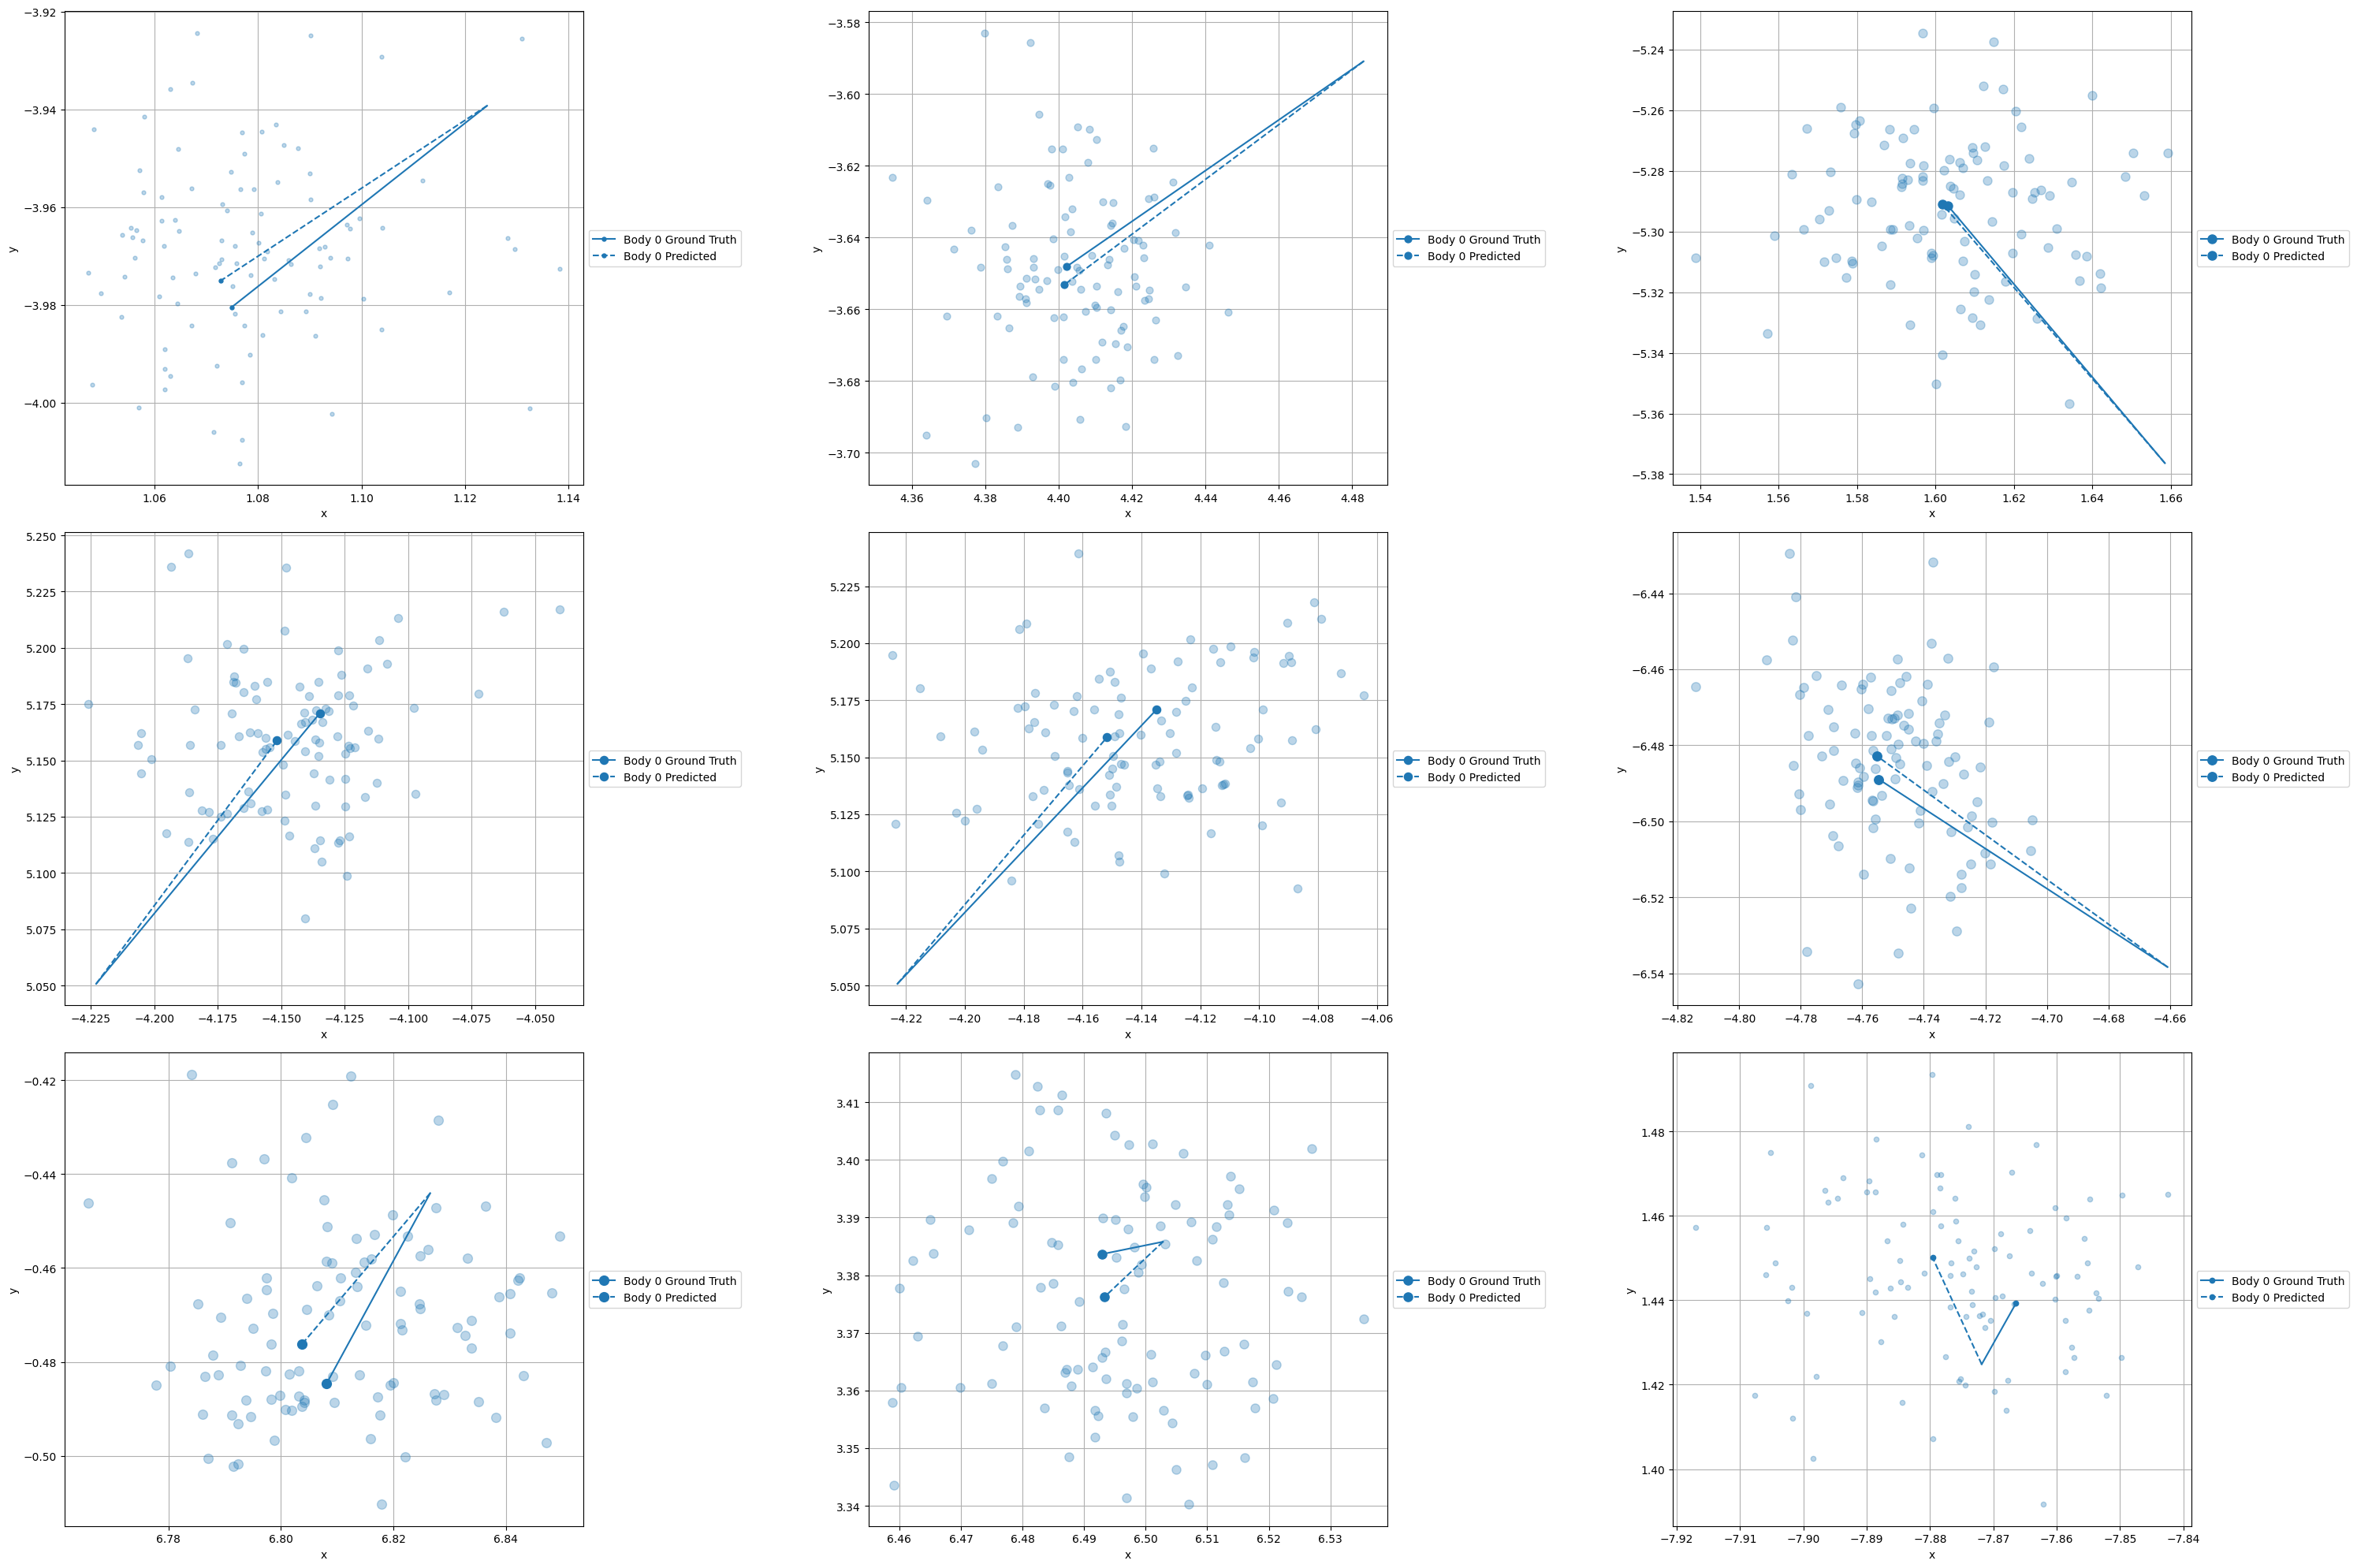

In [72]:
plot(model, test_data_loader, indices)